In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the CSV file
df = pd.read_csv("execution_times.csv")

# Display the first few rows of the data
print(df.head())

                  function_name  execution_time
0   SAVE_INPUT:CONTEXT_GETTER:1        0.023041
1    GET_INPUT:CONTEXT_GETTER:1        0.117105
2      CALL_FN:CONTEXT_GETTER:1        0.000141
3  SAVE_OUTPUT:CONTEXT_GETTER:1        0.010246
4   GET_OUTPUT:CONTEXT_GETTER:1        0.077273


In [25]:
df["operation"] = df["function_name"].apply(lambda x: x.split(":")[0])
df = df[~df["operation"].isin(["ITERATION"])]
df["component"] = df["function_name"].apply(lambda x: x.split(":")[1])
df["iteration"] = df["function_name"].apply(lambda x: x.split(":")[2])

df.head()

,function_name,execution_time,operation,component,iteration
0,SAVE_INPUT:CONTEXT_GETTER:1,0.023041,SAVE_INPUT,CONTEXT_GETTER,1
1,GET_INPUT:CONTEXT_GETTER:1,0.117105,GET_INPUT,CONTEXT_GETTER,1
2,CALL_FN:CONTEXT_GETTER:1,0.000141,CALL_FN,CONTEXT_GETTER,1
3,SAVE_OUTPUT:CONTEXT_GETTER:1,0.010246,SAVE_OUTPUT,CONTEXT_GETTER,1
4,GET_OUTPUT:CONTEXT_GETTER:1,0.077273,GET_OUTPUT,CONTEXT_GETTER,1


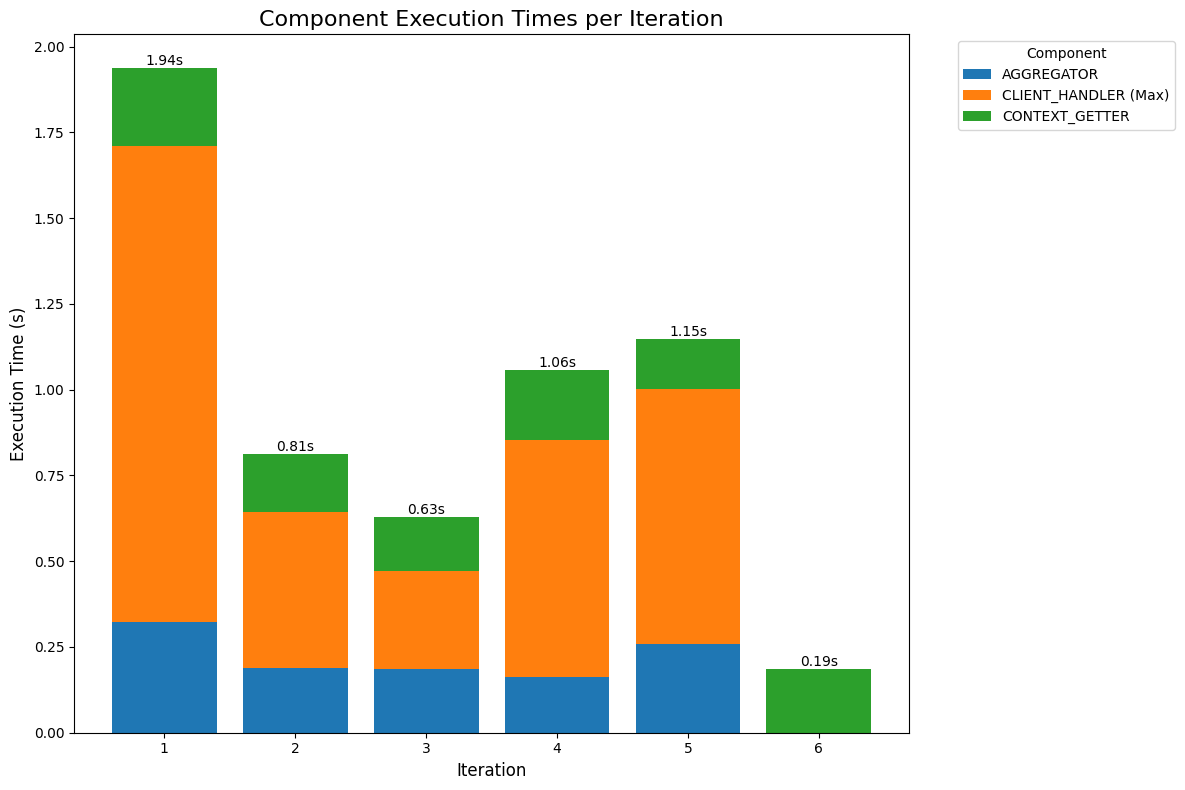

component  AGGREGATOR  CLIENT_HANDLER (Max)  CONTEXT_GETTER
count        6.000000              6.000000        6.000000
mean         0.185689              0.594744        0.181256
std          0.108377              0.475644        0.031192
min          0.000000              0.000000        0.145346
25%          0.167885              0.329246        0.158518
50%          0.186298              0.573620        0.177482
75%          0.240181              0.731306        0.199625
max          0.321646              1.389566        0.228022

Total Execution Time per Component:
component
CLIENT_HANDLER (Max)    3.568461
AGGREGATOR              1.114132
CONTEXT_GETTER          1.087535
dtype: float64


In [26]:
run_df = df[df["function_name"].str.startswith("RUN:")]

# Group client handlers and get max execution time per iteration
client_handlers = run_df[run_df["component"] == "CLIENT_HANDLER"].groupby("iteration")["execution_time"].max()
client_handlers = client_handlers.reset_index()
client_handlers["component"] = "CLIENT_HANDLER (Max)"

# Get other components
other_components = run_df[run_df["component"] != "CLIENT_HANDLER"]

# Combine client handlers with other components
combined_df = pd.concat([other_components, client_handlers])

# Pivot the data
pivot_df = combined_df.pivot(index="iteration", columns="component", values="execution_time")

# Fill NaN values with 0
pivot_df = pivot_df.fillna(0)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Create the stacked bar chart
bottom = np.zeros(len(pivot_df))
for column in pivot_df.columns:
    ax.bar(pivot_df.index, pivot_df[column], bottom=bottom, label=column)
    bottom += pivot_df[column]

# Customize the plot
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Execution Time (s)", fontsize=12)
ax.set_title("Component Execution Times per Iteration", fontsize=16)
ax.legend(title="Component", bbox_to_anchor=(1.05, 1), loc="upper left")

# Add value labels on the bars
for i, total in enumerate(bottom):
    ax.text(i, total, f"{total:.2f}s", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# Print summary statistics
print(pivot_df.describe())

# Print total execution time per component
print("\nTotal Execution Time per Component:")
print(pivot_df.sum().sort_values(ascending=False))

/tmp/ipykernel_22914/1343388520.py:11: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_components_avg = other_components_avg.append(pd.Series({"CLIENT_HANDLER (Max)": client_handlers_avg}))
/tmp/ipykernel_22914/1343388520.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("tab10")  # You can change 'tab10' to other colormaps like 'Set3', 'Paired', etc.


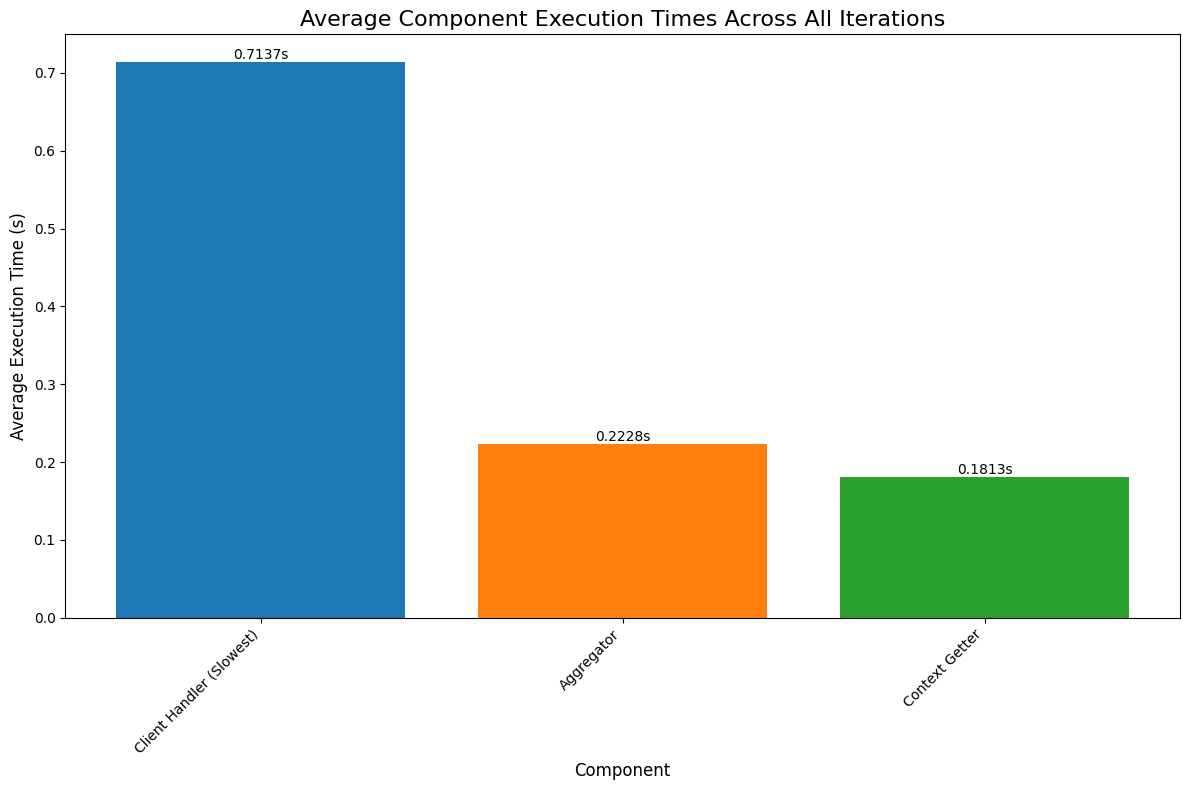

Average Execution Times per Component:
Client Handler (Slowest)    0.713692
Aggregator                  0.222826
Context Getter              0.181256
dtype: float64

Percentage of Total Execution Time:
Client Handler (Slowest): 63.85%
Aggregator: 19.93%
Context Getter: 16.22%


In [56]:
from matplotlib.cm import get_cmap


client_handlers_max = run_df[run_df["component"] == "CLIENT_HANDLER"].groupby("iteration")["execution_time"].max()
client_handlers_avg = client_handlers_max.mean()

# Calculate average execution times for other components
other_components_avg = run_df[run_df["component"] != "CLIENT_HANDLER"].groupby("component")["execution_time"].mean()

# Combine client handlers with other components
all_components_avg = other_components_avg.append(pd.Series({"CLIENT_HANDLER (Max)": client_handlers_avg}))

rename_dict = {
    "CONTEXT_GETTER": "Context Getter",
    "CLIENT_HANDLER (Max)": "Client Handler (Slowest)",
    "AGGREGATOR": "Aggregator",
}

all_components_avg.index = all_components_avg.index.map(rename_dict)


# Sort components by average execution time
all_components_avg_sorted = all_components_avg.sort_values(ascending=False)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

cmap = get_cmap("tab10")  # You can change 'tab10' to other colormaps like 'Set3', 'Paired', etc.

# Create the bar chart with different colors
bars = ax.bar(
    all_components_avg_sorted.index,
    all_components_avg_sorted.values,
    color=[cmap(i) for i in range(len(all_components_avg_sorted))],
)


# Customize the plot
ax.set_xlabel("Component", fontsize=12)
ax.set_ylabel("Average Execution Time (s)", fontsize=12)
ax.set_title("Average Component Execution Times Across All Iterations", fontsize=16)
plt.xticks(rotation=45, ha="right")

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height:.4f}s", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# Print average execution times
print("Average Execution Times per Component:")
print(all_components_avg_sorted)

# Calculate and print the percentage of total time for each component
total_time = all_components_avg_sorted.sum()
percentages = (all_components_avg_sorted / total_time) * 100

print("\nPercentage of Total Execution Time:")
for component, percentage in percentages.items():
    print(f"{component}: {percentage:.2f}%")

operation       GET_INPUT  SAVE_OUTPUT
component                             
AGGREGATOR       0.074406     0.029946
CLIENT_HANDLER   0.159167     0.026561
CONTEXT_GETTER   0.088201     0.008303


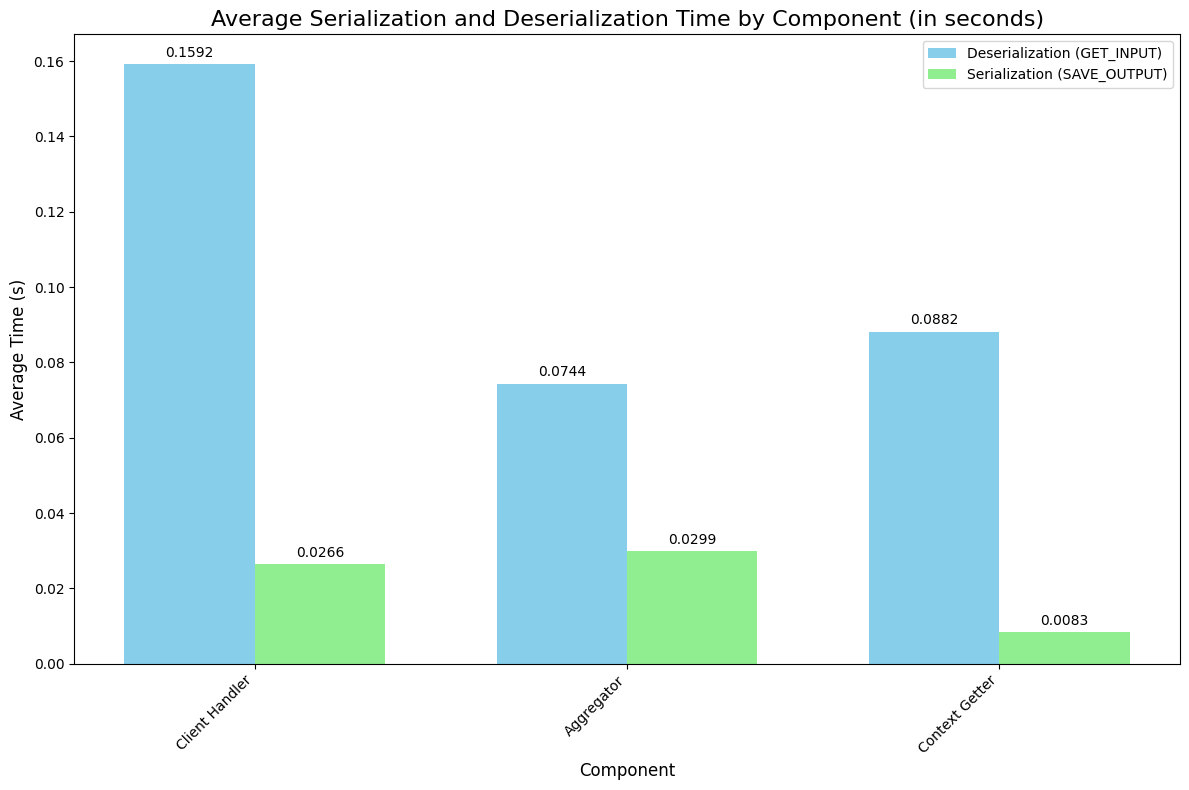

Average Serialization and Deserialization Times (in seconds):
                Deserialization  Serialization
component                                     
Client Handler         0.159167       0.026561
Aggregator             0.074406       0.029946
Context Getter         0.088201       0.008303

Total Overhead and Percentage by Component:
                Total Overhead  Percentage of Total Overhead
component                                                   
Client Handler        0.185728                     48.043379
Aggregator            0.104352                     26.993346
Context Getter        0.096504                     24.963275

Total Overhead Across All Components: 0.3866 seconds


In [55]:
# Filter for SAVE_OUTPUT and GET_INPUT operations
io_df = df[df["operation"].isin(["SAVE_OUTPUT", "GET_INPUT"])]


# Function to get average time (max for CLIENT_HANDLER)
def get_avg_time(group):
    if group.name == "CLIENT_HANDLER":
        return group.groupby(["iteration", "operation"])["execution_time"].max().groupby("operation").mean()
    else:
        return group.groupby("operation")["execution_time"].mean()


# Calculate average times
avg_times = io_df.groupby("component").apply(get_avg_time)

print(avg_times)

# Rename columns and index
column_rename = {"GET_INPUT": "Deserialization", "SAVE_OUTPUT": "Serialization"}
avg_times.columns = [column_rename.get(col, col) for col in avg_times.columns]
avg_times.index = avg_times.index.map(
    {"CONTEXT_GETTER": "Context Getter", "CLIENT_HANDLER": "Client Handler", "AGGREGATOR": "Aggregator"}
)


# Sort by total time (descending)
avg_times["Total"] = avg_times["Deserialization"] + avg_times["Serialization"]
avg_times_sorted = avg_times.sort_values("Total", ascending=False).drop("Total", axis=1)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set width of bars and positions of the bars on X axis
barWidth = 0.35
r1 = np.arange(len(avg_times_sorted))
r2 = [x + barWidth for x in r1]

# Create bars
deserialization_bars = ax.bar(
    r1, avg_times_sorted["Deserialization"], color="skyblue", width=barWidth, label="Deserialization (GET_INPUT)"
)
serialization_bars = ax.bar(
    r2, avg_times_sorted["Serialization"], color="lightgreen", width=barWidth, label="Serialization (SAVE_OUTPUT)"
)

# Customize the plot
ax.set_xlabel("Component", fontsize=12)
ax.set_ylabel("Average Time (s)", fontsize=12)
ax.set_title("Average Serialization and Deserialization Time by Component (in seconds)", fontsize=16)
ax.set_xticks([r + barWidth / 2 for r in range(len(avg_times_sorted))])
ax.set_xticklabels(avg_times_sorted.index, rotation=45, ha="right")
ax.legend()


# Add value labels on the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height:.4f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(deserialization_bars)
autolabel(serialization_bars)

plt.tight_layout()
plt.show()

# Print the average times
print("Average Serialization and Deserialization Times (in seconds):")
print(avg_times_sorted)

# Calculate and print the total overhead and percentage for each component
avg_times_sorted["Total Overhead"] = avg_times_sorted.sum(axis=1)
total_overhead = avg_times_sorted["Total Overhead"].sum()
avg_times_sorted["Percentage of Total Overhead"] = (avg_times_sorted["Total Overhead"] / total_overhead) * 100

print("\nTotal Overhead and Percentage by Component:")
print(avg_times_sorted[["Total Overhead", "Percentage of Total Overhead"]])
print(f"\nTotal Overhead Across All Components: {total_overhead:.4f} seconds")

/tmp/ipykernel_22914/3672257014.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['operation'] = df_filtered['operation'].map(operation_mapping)


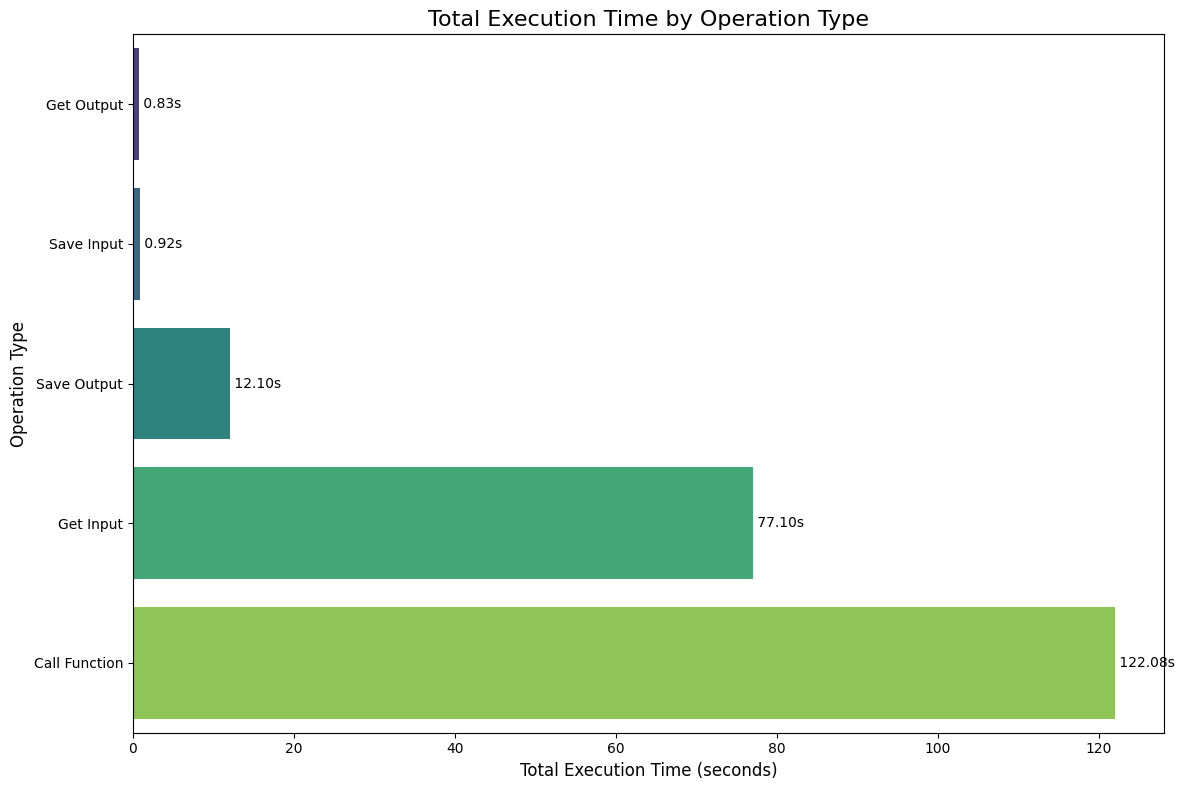

operation
Get Output         0.826200
Save Input         0.923413
Save Output       12.095868
Get Input         77.098361
Call Function    122.083974
Name: execution_time, dtype: float64


In [4]:
# Filter out 'RUN' and 'ITERATION'
df_filtered = df[~df["operation"].isin(["RUN", "ITERATION"])]

# Define a mapping for operation names
operation_mapping = {
    "SAVE_INPUT": "Save Input",
    "GET_INPUT": "Get Input",
    "CALL_FN": "Call Function",
    "SAVE_OUTPUT": "Save Output",
    "GET_OUTPUT": "Get Output",
}

# Apply the mapping to the operation column
df_filtered["operation"] = df_filtered["operation"].map(operation_mapping)

# Group by operation and sum the execution times
operation_times = df_filtered.groupby("operation")["execution_time"].sum().sort_values(ascending=True)

# Create a horizontal bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=operation_times.values, y=operation_times.index, orient="h", palette="viridis")

plt.title("Total Execution Time by Operation Type", fontsize=16)
plt.xlabel("Total Execution Time (seconds)", fontsize=12)
plt.ylabel("Operation Type", fontsize=12)

# Add value labels to the end of each bar
for i, v in enumerate(operation_times.values):
    plt.text(v, i, f" {v:.2f}s", va="center", fontsize=10)

plt.tight_layout()
plt.show()

# Print the total execution time for each operation type
print(operation_times)

/tmp/ipykernel_22914/1095661241.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_df['component'] = run_df['function_name'].apply(lambda x: x.split(':')[1])
/tmp/ipykernel_22914/1095661241.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_df['iteration'] = run_df['function_name'].apply(lambda x: x.split(':')[2])


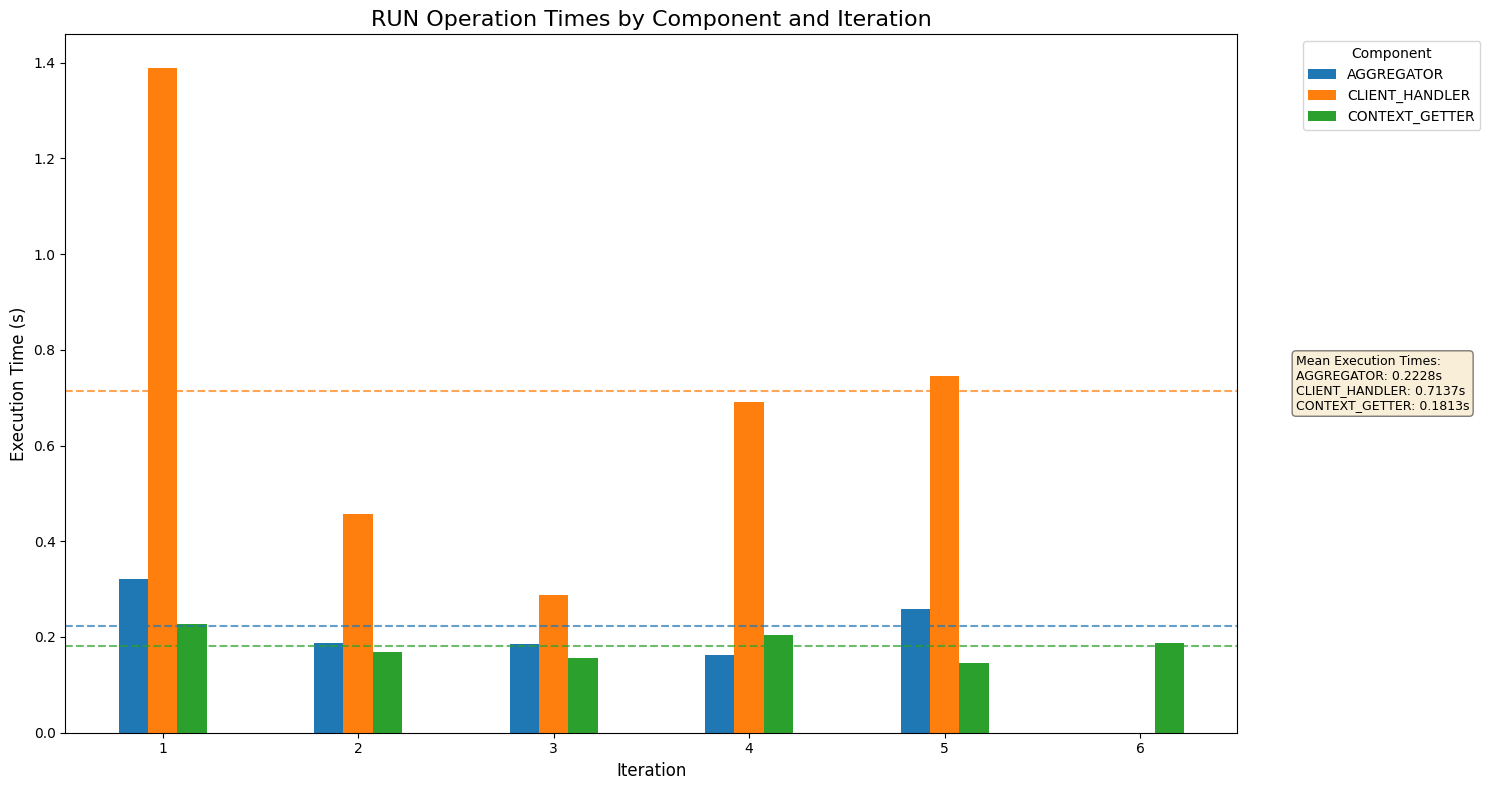

component  AGGREGATOR  CLIENT_HANDLER  CONTEXT_GETTER
iteration                                            
1            0.321646        1.389566        0.228022
2            0.187268        0.456127        0.168278
3            0.185329        0.286952        0.155265
4            0.162070        0.691113        0.203938
5            0.257819        0.744704        0.145346
6                 NaN             NaN        0.186686

Mean Execution Times:
component
AGGREGATOR        0.222826
CLIENT_HANDLER    0.713692
CONTEXT_GETTER    0.181256
dtype: float64


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = pd.read_csv("execution_times.csv")

# Filter for RUN operations
run_df = df[df["function_name"].str.startswith("RUN:")]

# Extract component and iteration
run_df["component"] = run_df["function_name"].apply(lambda x: x.split(":")[1])
run_df["iteration"] = run_df["function_name"].apply(lambda x: x.split(":")[2])

# For CLIENT_HANDLER, keep only the maximum time for each iteration
client_handler_max = (
    run_df[run_df["component"] == "CLIENT_HANDLER"].groupby("iteration")["execution_time"].max().reset_index()
)
client_handler_max["component"] = "CLIENT_HANDLER"

# Combine the CLIENT_HANDLER max times with other components
run_df_cleaned = pd.concat([run_df[run_df["component"] != "CLIENT_HANDLER"], client_handler_max])

# Pivot the data
pivot_df = run_df_cleaned.pivot(index="iteration", columns="component", values="execution_time")

# Calculate mean execution times
mean_times = pivot_df.mean()

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Set the width of each bar and the positions of the bars
width = 0.15
x = np.arange(len(pivot_df.index))

# Plot bars for each component
for i, component in enumerate(pivot_df.columns):
    ax.bar(x + i * width, pivot_df[component], width, label=component)

# Plot mean lines
for i, (component, mean_time) in enumerate(mean_times.items()):
    ax.axhline(y=mean_time, color=plt.cm.tab10(i), linestyle="--", alpha=0.7)

# Customize the plot
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Execution Time (s)", fontsize=12)
ax.set_title("RUN Operation Times by Component and Iteration", fontsize=16)
ax.set_xticks(x + width * (len(pivot_df.columns) - 1) / 2)
ax.set_xticklabels(pivot_df.index)
ax.legend(title="Component", bbox_to_anchor=(1.05, 1), loc="upper left")

# Add a text box with mean times
meantext = "Mean Execution Times:\n" + "\n".join(
    [f"{component}: {time:.4f}s" for component, time in mean_times.items()]
)
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
ax.text(1.05, 0.5, meantext, transform=ax.transAxes, fontsize=9, verticalalignment="center", bbox=props)

plt.tight_layout()
plt.show()

# Print the data
print(pivot_df)
print("\nMean Execution Times:")
print(mean_times)

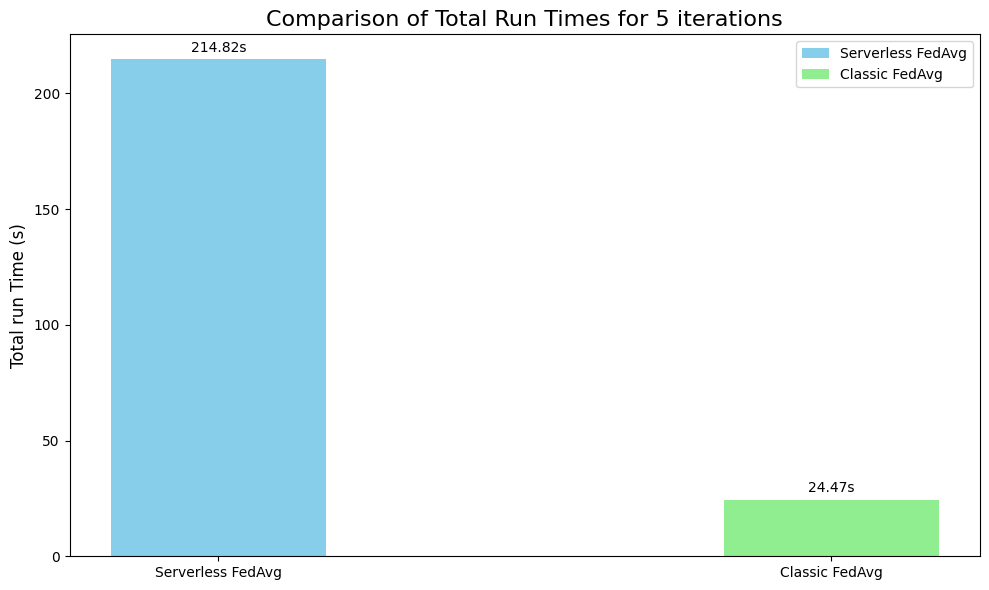

Total Iteration Time (File 1): 214.82 seconds
Total Iteration Time (File 2): 24.47 seconds
Percentage Difference: -88.61%


In [12]:
def process_csv(file_path):
    df = pd.read_csv(file_path)
    iteration_times = df[df["function_name"].str.startswith("ITERATION:")]["execution_time"]
    return iteration_times.sum()


# File paths
file1 = "execution_times.csv"  # Replace with your first file path
file2 = "original.csv"  # Replace with your second file path

# Process both files
time1 = process_csv(file1)
time2 = process_csv(file2)

# Calculate percentage difference
percent_diff = ((time2 - time1) / time1) * 100

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width of each bar and the positions of the bars
width = 0.35
x = np.arange(2)

# Plot bars
bars1 = ax.bar(x[0], time1, width, label="Serverless FedAvg", color="skyblue")
bars2 = ax.bar(x[1], time2, width, label="Classic FedAvg", color="lightgreen")

# Customize the plot
ax.set_ylabel("Total run Time (s)", fontsize=12)
ax.set_title("Comparison of Total Run Times for 5 iterations", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(["Serverless FedAvg", "Classic FedAvg"])
ax.legend()


# Add value labels on the bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.2f}s",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(bars1)
autolabel(bars2)

# Add percentage difference
# ax.annotate(f'{percent_diff:.2f}% difference',
#             xy=(0.5, max(time1, time2)),
#             xytext=(0, 10),  # 10 points vertical offset
#             textcoords="offset points",
#             ha='center', va='bottom',
#             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print the results
print(f"Total Iteration Time (File 1): {time1:.2f} seconds")
print(f"Total Iteration Time (File 2): {time2:.2f} seconds")
print(f"Percentage Difference: {percent_diff:.2f}%")

PONIŻĘJ NIE DZIALA

In [ ]:
# Extract component and iteration from function_name
df["component"] = df["function_name"].apply(lambda x: x.split(":")[1])
df["iteration"] = df["function_name"].apply(lambda x: x.split(":")[2])

# Convert iteration to numeric type
df["iteration"] = pd.to_numeric(df["iteration"], errors="coerce")

# 1. Average execution time per component
plt.figure(figsize=(12, 6))
sns.barplot(x="component", y="execution_time", data=df)
plt.title("Average Execution Time per Component")
plt.xlabel("Component")
plt.ylabel("Execution Time (s)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 2. Execution time comparison across iterations for AGGREGATOR
aggregator_df = df[df["component"] == "AGGREGATOR"]
plt.figure(figsize=(12, 6))
sns.lineplot(x="iteration", y="execution_time", data=aggregator_df)
plt.title("AGGREGATOR Execution Time Across Iterations")
plt.xlabel("Iteration")
plt.ylabel("Execution Time (s)")
plt.show()

In [ ]:
# 3. Distribution of execution times for CLIENT_HANDLER
client_handler_df = df[df["component"] == "CLIENT_HANDLER"]
plt.figure(figsize=(12, 6))
sns.boxplot(x="iteration", y="execution_time", data=client_handler_df)
plt.title("Distribution of CLIENT_HANDLER Execution Times")
plt.xlabel("Iteration")
plt.ylabel("Execution Time (s)")
plt.show()

# 4. Cumulative execution time per iteration
pivot_df = df.pivot_table(values="execution_time", index="iteration", columns="component", aggfunc="sum")
pivot_df.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Cumulative Execution Time per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Execution Time (s)")
plt.legend(title="Component", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 5. Heatmap of execution times
pivot_df = df.pivot_table(values="execution_time", index="iteration", columns="component", aggfunc="mean")
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap="YlOrRd", fmt=".3f")
plt.title("Heatmap of Execution Times")
plt.show()

# 6. Execution time trends for all components
plt.figure(figsize=(12, 6))
for component in df["component"].unique():
    component_df = df[df["component"] == component]
    sns.lineplot(x="iteration", y="execution_time", data=component_df, label=component)
plt.title("Execution Time Trends for All Components")
plt.xlabel("Iteration")
plt.ylabel("Execution Time (s)")
plt.legend(title="Component")
plt.show()

# 7. Correlation between components
pivot_df = df.pivot_table(values="execution_time", index="iteration", columns="component", aggfunc="mean")
correlation = pivot_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation Between Components")
plt.show()

# Print summary statistics
print(df.groupby("component")["execution_time"].describe())